Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


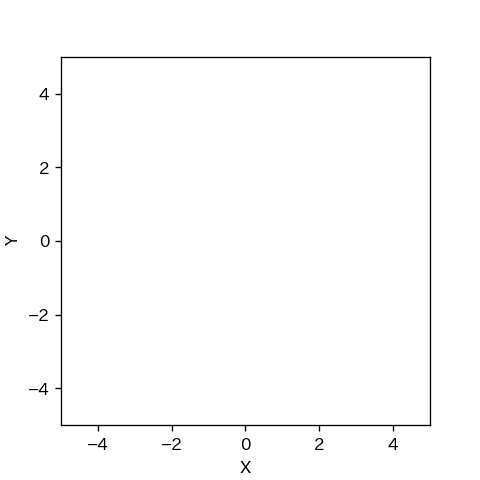

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red")
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


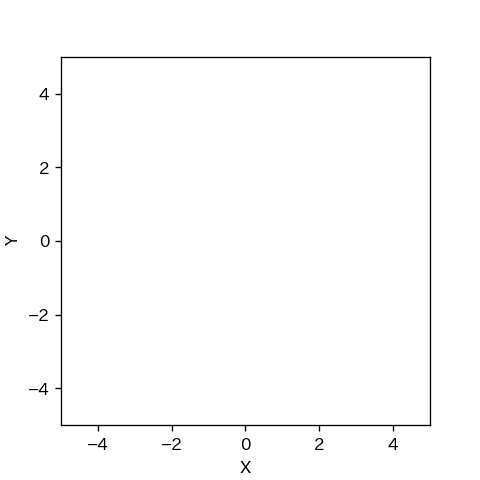

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_phantom(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[5.647391661613828, 5.014657789307064]
[4.224756660615679, 4.531694847972497]
[3.5448877869090096, 4.582814243504654]
[4.205896008719649]
[4.695570305333823]
[2.42882516136382]
[3.7260810879662776]
[4.149554579336807, 3.7858330288463726]
[5.088802463350654]
[2.889891526753181]
[3.536618113136065]
[3.7396731953708566]
[3.2109608188178096, 3.500822776987301]
[3.564753063588347]
[4.243374596858337, 3.229973964909818]
[3.8813464558316086]
[4.117725007591496, 1.9085673610689364]
[3.5425803988014835]
[3.3824564568839177, 6.5430325789825545]
0 真値: [-1.00095277  1.52942729  4.36499744] 推定値: [ 3.75029163 -8.87850362  0.86175418] 誤差: 11.441125344561012
[3.5882687646858744, 3.166434952429211]
[3.689376950083494]
[3.2309311383023536]
[3.368596934928687]
[2.8060332167601807]
[1.6870067845063712, 2.599487409996417]
[2.0802874105381637, 1.7971016796042225]
[3.1577235458198394]
[4.2982397150143115]
[4.96411026405294, 3.9915429316470257]
[4.264694902523628]
[4.041214676639452, 5.082982351175124]
[4.475

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.3590825287300676, 3.0850524000179207]
[3.793752881957246]
[3.5633860203465835]
[2.3862133014178837, 3.0517522193809876]
[2.6086626358642864, 2.0684739768747207]
[5.671001229474511]
[5.4062241264156885, 3.432019787524604]
[4.34159516707234]
[3.570641305216193, 3.4819487372068716]
[4.8490691794909075]
[4.340691990312828, 5.430580262593561]
[3.8158616368338087]
[4.172331634611016, 4.513867831430652]
[4.479751525132638]
[1.8295310830213545]
[3.6431845354082473]
[2.0257040417508008]
[3.478138243720615]
[3.501689954575002, 3.91839453909062]
[2.7408306177805843]
[2.896871240794318]
[3.747325089153843]
[3.2811263260883576]
[3.1820886347618402, 1.641996383154763]
[2.7372421578773336]
[1.8081860196840196]
[3.002483894023834]
[4.528215812780981]
[2.7554769531262435]
[5.420046161904372]
[5.465361419269903]
[5.985527149059447]
20 真値: [-1.5162328   1.66060033  4.72056303] 推定値: [ 8.58059884 -1.62549802 -3.58375495] 誤差: 10.618119011967822
[3.7428703912787027]
[4.1359668692960945]
[3.970343347370371